# Data preprocessing

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

In [0]:
df = pd.read_csv("training.csv").drop('Unnamed: 0', 1)
df_test = pd.read_csv("test.csv").drop('Unnamed: 0', 1)

In [0]:
df = df.sort_values(by='date')
df_test = df_test.sort_values(by='date')

# 1. Training preprocessing

In [0]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1743,2015-02-04 17:51:00,23.18,27.272,426.0,721.250000,0.004793,1
8291,2015-02-04 17:53:00,23.15,27.245,426.0,713.500000,0.004779,1
7214,2015-02-04 17:55:00,23.10,27.200,426.0,704.500000,0.004757,1
6095,2015-02-04 17:55:59,23.10,27.200,419.0,701.000000,0.004757,1
4165,2015-02-04 17:57:00,23.10,27.200,419.0,701.666667,0.004757,1


## 1.1 Feature engineering 1

In [0]:
from datetime import datetime

In [0]:
# Set the parser datetime format
def date_obj(st):
    """
    Converts a string into a datetime object 
    """
    date_format = '%Y-%m-%d %H:%M:%S'
    return datetime.strptime(st, date_format)

dates = df.date
print(type(dates))

<class 'pandas.core.series.Series'>


Adding time attributes to df

In [0]:
df['Date'] = dates.apply(lambda x: date_obj(x).strftime("%m-%d-%y")) # This is useful if the comparison for dates is needed
df['Time'] = dates.apply(lambda x: date_obj(x).strftime("%H:%M:%S")) # This is useful for comparing the day's hours
df['Year'] = dates.apply(lambda x: date_obj(x).year)
df['Month'] = dates.apply(lambda x: date_obj(x).month)
df['Day'] = dates.apply(lambda x: date_obj(x).day)
df['WeekDay'] = dates.apply(lambda x: date_obj(x).strftime('%A'))

df['Hour'] = dates.apply(lambda x: date_obj(x).hour)
df['Minute'] = dates.apply(lambda x: date_obj(x).minute)
df['Second'] = dates.apply(lambda x: date_obj(x).second)

Ore e giorni in cui la stanza è vuota:

In [0]:
for day in df['WeekDay'].unique():
    print(day)
    print(df[(df['WeekDay'] == day ) & (df['Occupancy'] == 0)]['Hour'].unique())

Wednesday
[18 19 20 21 22 23 15  0  1  2  3  4  5  6  7  8  9]
Thursday
[ 0  1  2  3  4  5  6  7 10 12 13 14 18 19 20 21 22 23  8 11 15 16 17]
Friday
[ 0  1  2  3  4  5  6  7 11 12 13 18 19 20 21 22 23  8  9 10 17]
Saturday
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Sunday
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Monday
[ 0  1  2  3  4  5  6  7  8 13 18 19 20 21 22 23 11 12]
Tuesday
[ 0  1  2  3  4  5  6  7  8 13 18 19 20 21 22 23]


Ore (con minuti) e giorni in cui la stanza è vuota.
Il codice è scritto in modo da riportare solo il primo e l'ultimo minuto, per ogni ora di ogni giorno, in cui la stanza è vuota:

In [0]:
for day in df['WeekDay'].unique():
    times_occupancy_0 = df[(df['WeekDay'] == day ) & (df['Occupancy'] == 0)]['Time'].unique()
    
    times_condensed = []
    index = 0
    for element in times_occupancy_0:
        if index == 0:
            times_condensed.append(element)
            hours = element[0:2]
            #minutes_init = element[3:5]
        if index == times_occupancy_0.size - 1:
            times_condensed.append(element)
        elif element[0:2] != hours:
            if times_occupancy_0[index-1] not in times_condensed:
                times_condensed.append(times_occupancy_0[index-1])
            times_condensed.append(element)
            hours = element[0:2]
        index +=1
    print(day)
    print(times_condensed)
        

Wednesday
['18:07:00', '18:58:00', '19:00:00', '19:57:00', '20:00:59', '20:58:59', '21:01:00', '21:59:00', '22:01:00', '22:59:00', '23:02:00', '23:58:59', '15:24:59', '15:26:00', '18:36:59', '18:59:00', '19:05:00', '19:59:59', '20:10:59', '20:57:00', '21:00:00', '21:42:00', '22:00:00', '22:57:00', '23:00:59', '23:49:00', '00:00:00', '00:59:00', '01:01:00', '01:59:00', '02:02:00', '02:58:59', '03:00:00', '03:56:59', '04:01:59', '04:59:59', '05:00:59', '05:58:59', '06:00:00', '06:58:00', '07:01:00', '07:59:00', '08:02:00', '08:57:00', '09:00:00', '09:10:00']
Thursday
['00:00:00', '00:58:00', '01:00:00', '01:59:59', '02:00:59', '02:58:59', '03:00:00', '03:59:00', '04:00:00', '04:59:59', '05:00:59', '05:58:59', '06:01:00', '06:59:00', '07:00:00', '07:40:59', '10:23:00', '10:25:00', '12:33:00', '12:59:00', '13:00:00', '13:56:00', '14:00:59', '14:10:59', '18:04:59', '18:59:00', '19:01:59', '19:59:59', '20:00:59', '20:58:59', '21:01:00', '21:59:00', '22:01:00', '22:59:00', '23:02:00', '23:58:

Questi dati potrebbero essere utili per sapere come paragonare i vari record. Ad esempio, che la temperatura sia mediamente più bassa per i record con Occupancy = 0 potrebbe non significare nulla, perché ci entrano dentro fasce orarie in cui la temperatura è a prescindere più bassa. Le varie misure, quindi, andrebbero aggiustate sulla base di considerazioni di questo genere.

<b> Creating a new binary variable ('WorkingHours') that captures whether the time was a working hour (1) or not (0) </b>

In [0]:
df['WorkingHours'] = 0
for index in df.index:
    if (df.at[index, 'WeekDay']!= 'Sunday') & (df.at[index, 'WeekDay']!= 'Saturday'):
        if (df.at[index, 'Time'] < '18:00:00') & (df.at[index, 'Time'] > '07:00:00'):
            df.at[index, 'WorkingHours'] = 1

# ------------------------------------------------------------------------------------------

## 1.2 Feature selection 1

In [0]:
df = df.drop(columns=['Date', 'date', 'Second','HumidityRatio', 'Day', 'Month','Year'])

<b> Remaining attributes: </b>

In [0]:
df.head()

,Temperature,Humidity,Light,CO2,Occupancy,Time,WeekDay,Hour,Minute,WorkingHours
1743,23.18,27.272,426.0,721.250000,1,17:51:00,Wednesday,17,51,1
8291,23.15,27.245,426.0,713.500000,1,17:53:00,Wednesday,17,53,1
7214,23.10,27.200,426.0,704.500000,1,17:55:00,Wednesday,17,55,1
6095,23.10,27.200,419.0,701.000000,1,17:55:59,Wednesday,17,55,1
4165,23.10,27.200,419.0,701.666667,1,17:57:00,Wednesday,17,57,1


# ------------------------------------------------------------------------------------------

Another thing that might be tried is an hour-by-hour comparison, that would neutralise the within-day variation of some variables like temperature

In [0]:
#creating appropriate row multiindex

rows_first = ['Temperature', 'Humidity','Light', 'CO2']
rows_second = ['count', 'avg', 'std', 'median', 'min', 'max']
rows = ()
for attribute in rows_first:
    for stat in rows_second:
        rows += (attribute, stat),
rows_index = list(rows)

In [0]:
row_index = pd.MultiIndex.from_tuples(rows_index, names=['Attribute', 'Stats'])

In [0]:
#creating appropriate column multiindex

columns_first = list(np.arange(0, 24))
columns_second = list((0,1))
columns = ()
for hour in columns_first:
    for boolean in columns_second:
         columns += (hour, boolean),
columns_index = list(columns)

In [0]:
column_index = pd.MultiIndex.from_tuples(columns_index, names=['Hour', 'Occupancy'])

In [0]:
# creating dictionaries mapping each hour to attribute values recorded for that hour (throughout the days)

attributes = ['Temperature', 'Humidity', 'Light', 'CO2']
list_of_dicts = []
for attribute in attributes:
    count = {}
    avg = {}
    std = {}
    median = {}
    min_m = {}
    max_m = {}
    for hour in df['Hour'].unique():
        
        no_zeroes = False
        no_ones = False
        boolean_0 = (df['Hour'] == hour) & (df['Occupancy']==0)
        boolean_1 = (df['Hour'] == hour) & (df['Occupancy']==1)
        
        attr_0 = df[boolean_0][attribute].values
        if attr_0.size==0:
            attr_0 = np.zeros(1)
            no_zeroes = True
        attr_1 = df[boolean_1][attribute].values
        if attr_1.size==0:
            attr_1 = np.zeros(1)
            no_ones = True
        
        if no_zeroes:
            count[int(hour), 'Empty'] = 0
        else:
            count[int(hour), 'Empty'] = attr_0.size
        if no_ones:
            count[int(hour), 'Occupied'] =  0
        else:
            count[int(hour), 'Occupied'] =  attr_1.size
        avg[int(hour), 'Empty'] = round(attr_0.mean(), 2)
        avg[int(hour), 'Occupied'] = round(attr_1.mean(), 2)
        std[int(hour), 'Empty'] =  round(attr_0.std(), 2)
        std[int(hour), 'Occupied'] = round(attr_1.std(), 2)
        median[int(hour), 'Empty'] =  round(np.median(np.sort(attr_0)),2)
        median[int(hour), 'Occupied'] =  round(np.median(np.sort(attr_1)),2)
        min_m[int(hour), 'Empty'] =  round(attr_0.min(), 2)
        min_m[int(hour), 'Occupied'] =  round(attr_1.min(), 2)
        max_m[int(hour), 'Empty'] =  round(attr_0.max(), 2)
        max_m[int(hour), 'Occupied'] = round(attr_1.max(), 2)   
    list_of_dicts += count, avg, std, median, min_m, max_m
    
len(list_of_dicts)

24

In [0]:
df_hbh = pd.DataFrame(list_of_dicts)

df_hbh.set_axis(column_index, 1)
df_hbh.set_axis(row_index, 0)

df_hbh

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  after removing the cwd from sys.path.


Hour                     0             1             2             3        \
Occupancy                 0    1        0    1        0    1        0    1   
Attribute   Stats                                                            
Temperature count    534.00  0.0   522.00  0.0   531.00  0.0   533.00  0.0   
            avg       20.27  0.0    20.25  0.0    20.22  0.0    20.21  0.0   
            std        0.50  0.0     0.52  0.0     0.53  0.0     0.53  0.0   
            median    20.20  0.0    20.29  0.0    20.29  0.0    20.20  0.0   
            min       19.39  0.0    19.29  0.0    19.34  0.0    19.29  0.0   
            max       21.29  0.0    21.20  0.0    21.10  0.0    21.00  0.0   
Humidity    count    534.00  0.0   522.00  0.0   531.00  0.0   533.00  0.0   
            avg       28.30  0.0    27.83  0.0    27.74  0.0    27.42  0.0   
            std        4.64  0.0     4.90  0.0     4.94  0.0     5.12  0.0   
            median    29.00  0.0    27.60  0.0    27.00  0.0    26.60  0.0   
            min       18.60  0.0    18.60  0.0    18.86  0.0    18.70  0.0   
            max       35.70  0.0    35.95  0.0    36.50  0.0    36.63  0.0   
Light       count    534.00  0.0   522.00  0.0   531.00  0.0   533.00  0.0   
            avg        0.00  0.0     0.00  0.0     0.00  0.0     0.00  0.0   
            std        0.00  0.0     0.00  0.0     0.00  0.0     0.00  0.0   
            median     0.00  0.0     0.00  0.0     0.00  0.0     0.00  0.0   
            min        0.00  0.0     0.00  0.0     0.00  0.0     0.00  0.0   
            max        0.00  0.0     0.00  0.0     0.00  0.0     0.00  0.0   
CO2         count    534.00  0.0   522.00  0.0   531.00  0.0   533.00  0.0   
            avg      587.83  0.0   600.43  0.0   593.01  0.0   605.06  0.0   
            std      231.29  0.0   272.26  0.0   223.54  0.0   247.37  0.0   
            median   505.42  0.0   502.25  0.0   505.50  0.0   503.00  0.0   
            min      432.00  0.0   431.00  0.0   427.50  0.0   424.00  0.0   
            max     1879.50  0.0  2076.50  0.0  1285.00  0.0  1415.00  0.0   

Hour                     4        ...       19            20            21  \
Occupancy                 0    1  ...        0    1        0    1        0   
Attribute   Stats                 ...                                        
Temperature count    534.00  0.0  ...   536.00  0.0   509.00  0.0   520.00   
            avg       20.19  0.0  ...    20.74  0.0    20.58  0.0    20.46   
            std        0.53  0.0  ...     0.70  0.0     0.60  0.0     0.54   
            median    20.29  0.0  ...    20.79  0.0    20.50  0.0    20.39   
            min       19.29  0.0  ...    19.20  0.0    19.39  0.0    19.39   
            max       21.00  0.0  ...    22.29  0.0    21.79  0.0    21.57   
Humidity    count    534.00  0.0  ...   536.00  0.0   509.00  0.0   520.00   
            avg       27.27  0.0  ...    28.77  0.0    28.51  0.0    28.47   
            std        5.26  0.0  ...     5.11  0.0     4.99  0.0     4.60   
            median    26.26  0.0  ...    29.53  0.0    29.50  0.0    29.36   
            min       18.60  0.0  ...    19.20  0.0    19.10  0.0    18.89   
            max       37.53  0.0  ...    36.20  0.0    35.50  0.0    35.40   
Light       count    534.00  0.0  ...   536.00  0.0   509.00  0.0   520.00   
            avg        0.00  0.0  ...     0.00  0.0     0.00  0.0     0.00   
            std        0.00  0.0  ...     0.00  0.0     0.00  0.0     0.00   
            median     0.00  0.0  ...     0.00  0.0     0.00  0.0     0.00   
            min        0.00  0.0  ...     0.00  0.0     0.00  0.0     0.00   
            max        0.00  0.0  ...     0.00  0.0     0.00  0.0     0.00   
CO2         count    534.00  0.0  ...   536.00  0.0   509.00  0.0   520.00   
            avg      596.62  0.0  ...   654.24  0.0   618.57  0.0   620.30   
            std      260.28  0.0  ...   278.63  0.0   259.29  0.0   287.94   
            median   

In [0]:
df_hbh[17,0]['Temperature']['median']

20.39

## 1.3 Feature engineering 2

In [0]:
for attribute in ['Temperature','Humidity','Light', 'CO2']:
        df['Delta ' + attribute] = 0.0        
for index in df.index:
    for attribute in ['Temperature','Humidity','Light', 'CO2']:
        for hour in df['Hour'].unique():
            if df.at[index, 'Hour'] == hour:
                df.at[index, 'Delta ' + attribute] = df.at[index, attribute] - df_hbh[hour, 0][attribute]['median']


In [0]:
df.head()

,Temperature,Humidity,Light,CO2,Occupancy,Time,WeekDay,Hour,Minute,WorkingHours,Delta Temperature,Delta Humidity,Delta Light,Delta CO2
1743,23.18,27.272,426.0,721.250000,1,17:51:00,Wednesday,17,51,1,2.79,-0.828,420.0,207.580000
8291,23.15,27.245,426.0,713.500000,1,17:53:00,Wednesday,17,53,1,2.76,-0.855,420.0,199.830000
7214,23.10,27.200,426.0,704.500000,1,17:55:00,Wednesday,17,55,1,2.71,-0.900,420.0,190.830000
6095,23.10,27.200,419.0,701.000000,1,17:55:59,Wednesday,17,55,1,2.71,-0.900,413.0,187.330000
4165,23.10,27.200,419.0,701.666667,1,17:57:00,Wednesday,17,57,1,2.71,-0.900,413.0,187.996667


Analysing the new variables' distribution (mainly to make sure computations were right and idea makes sense):

In [0]:
import seaborn as sns
# set the plt style in order to have uniform graphical variables
plt.style.use('seaborn')

Text(0.5, 1.0, 'Delta Temperature')

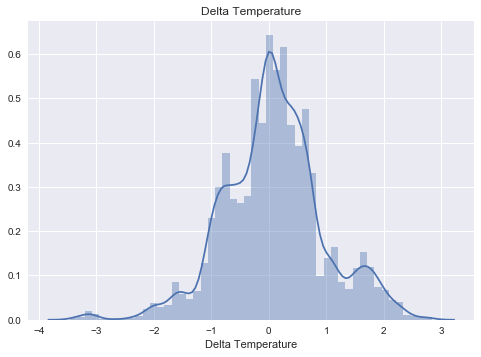

In [0]:
sns.distplot(df['Delta Temperature']).set_title('Delta Temperature')

Text(0, 0.5, 'Count')

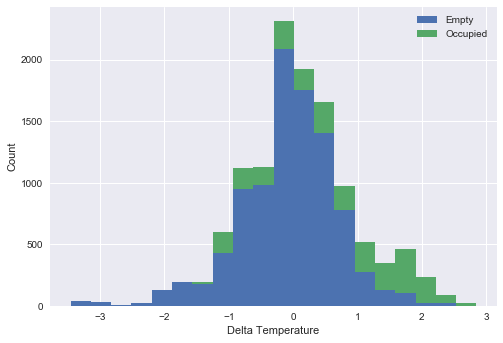

In [0]:
df1 = df[df['Occupancy'] == 0]['Delta Temperature']
df2 = df[df['Occupancy'] == 1]['Delta Temperature']

fig = plt.figure()
ax = plt.axes()

ax.hist([df1,df2], stacked= True, bins = 20)
ax.legend(('Empty', 'Occupied'), loc='best')
ax.set_xlabel('Delta Temperature')
ax.set_ylabel('Count')

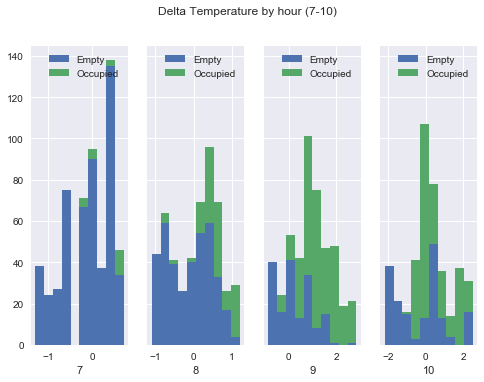

In [0]:
fig, ax = plt.subplots(1, 4, sharey='row')
fig.suptitle('Delta Temperature by hour (7-10)')

i = 0
for hour in range(7,11):
    df1 = df[(df['Occupancy'] == 0) & (df['Hour']== hour)]['Delta Temperature']
    df2 = df[(df['Occupancy'] == 1) & (df['Hour']== hour)]['Delta Temperature']
    ax[i].hist([df1,df2], stacked= True)
    ax[i].legend(('Empty', 'Occupied'), loc='best')
    ax[i].set_xlabel(hour)
    if i == 3:
        break
    else:
        i +=1

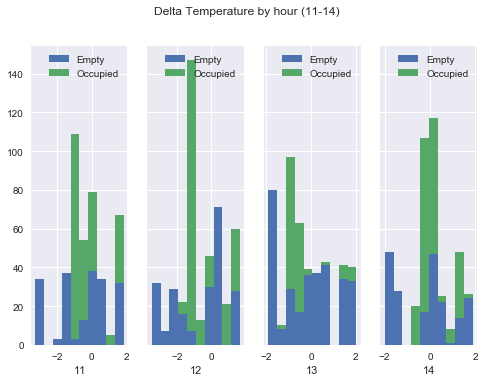

In [0]:
fig, ax = plt.subplots(1, 4, sharey='row')
fig.suptitle('Delta Temperature by hour (11-14)')

i = 0
for hour in range(11,15):
    df1 = df[(df['Occupancy'] == 0) & (df['Hour']== hour)]['Delta Temperature']
    df2 = df[(df['Occupancy'] == 1) & (df['Hour']== hour)]['Delta Temperature']
    ax[i].hist([df1,df2], stacked= True)
    ax[i].legend(('Empty', 'Occupied'), loc='best')
    ax[i].set_xlabel(hour)
    if i == 3:
        break
    else:
        i +=1

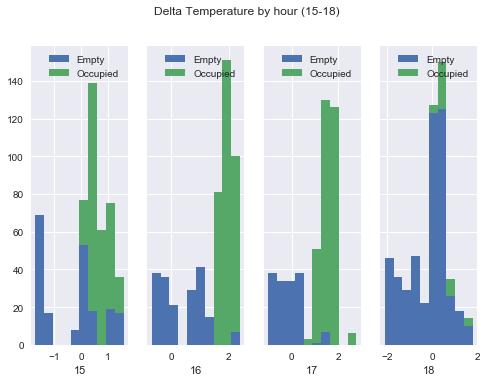

In [0]:
fig, ax = plt.subplots(1, 4, sharey='row')
fig.suptitle('Delta Temperature by hour (15-18)')

i = 0
for hour in range(15,19):
    df1 = df[(df['Occupancy'] == 0) & (df['Hour']== hour)]['Delta Temperature']
    df2 = df[(df['Occupancy'] == 1) & (df['Hour']== hour)]['Delta Temperature']
    ax[i].hist([df1,df2], stacked= True)
    ax[i].legend(('Empty', 'Occupied'), loc='best')
    ax[i].set_xlabel(hour)
    if i == 3:
        break
    else:
        i += 1

Text(0.5, 1.0, 'Delta Light')

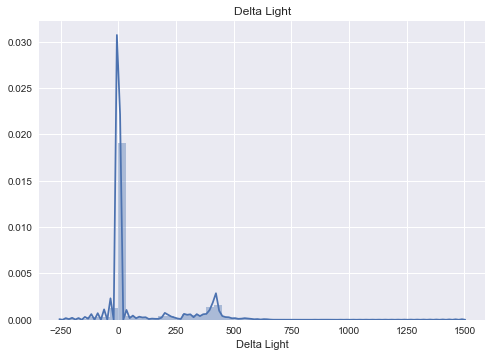

In [0]:
sns.distplot(df['Delta Light']).set_title('Delta Light')

Text(0, 0.5, 'Count')

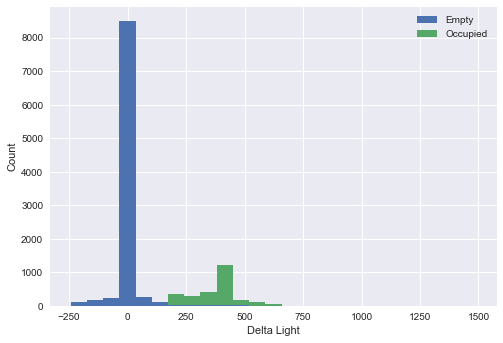

In [0]:
df1 = df[df['Occupancy'] == 0]['Delta Light']
df2 = df[df['Occupancy'] == 1]['Delta Light']

fig = plt.figure()
ax = plt.axes()

ax.hist([df1,df2], stacked= True, bins= 25)
ax.legend(('Empty', 'Occupied'), loc='best')
ax.set_xlabel('Delta Light')
ax.set_ylabel('Count')

Text(0.5, 1.0, 'Delta CO2')

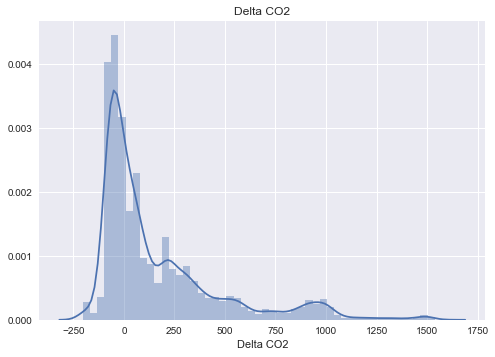

In [0]:
sns.distplot(df['Delta CO2']).set_title('Delta CO2')

Text(0, 0.5, 'Count')

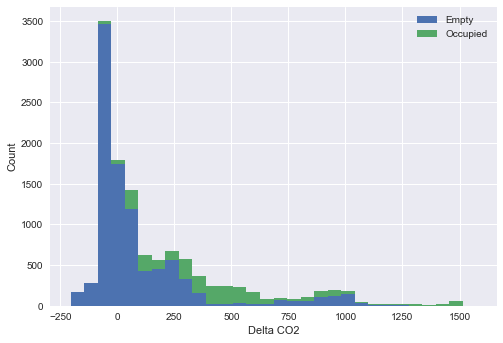

In [0]:
df1 = df[df['Occupancy'] == 0]['Delta CO2']
df2 = df[df['Occupancy'] == 1]['Delta CO2']

fig = plt.figure()
ax = plt.axes()

ax.hist([df1,df2], stacked= True, bins= 30)
ax.legend(('Empty', 'Occupied'), loc='best')
ax.set_xlabel('Delta CO2')
ax.set_ylabel('Count')

Text(0.5, 1.0, 'Delta Humidity')

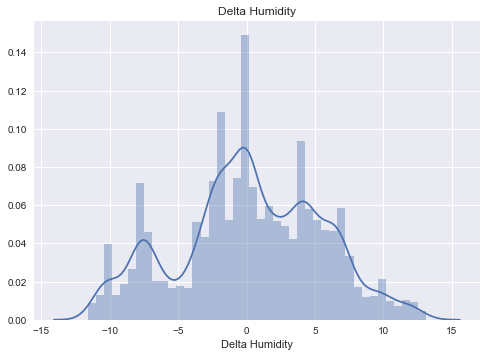

In [0]:
sns.distplot(df['Delta Humidity']).set_title('Delta Humidity')

Text(0, 0.5, 'Count')

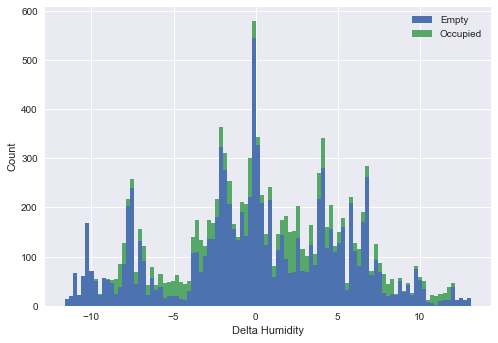

In [0]:
df1 = df[df['Occupancy'] == 0]['Delta Humidity']
df2 = df[df['Occupancy'] == 1]['Delta Humidity']

fig = plt.figure()
ax = plt.axes()

ax.hist([df1,df2], stacked= True, bins= 100)
ax.legend(('Empty', 'Occupied'), loc='best')
ax.set_xlabel('Delta Humidity')
ax.set_ylabel('Count')

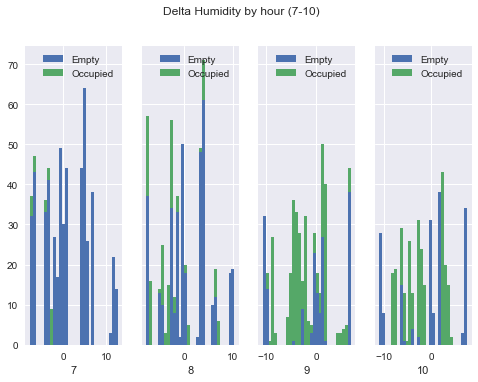

In [0]:
fig, ax = plt.subplots(1, 4, sharey='row')
fig.suptitle('Delta Humidity by hour (7-10)')

i = 0
for hour in range(7,11):
    df1 = df[(df['Occupancy'] == 0) & (df['Hour']== hour)]['Delta Humidity']
    df2 = df[(df['Occupancy'] == 1) & (df['Hour']== hour)]['Delta Humidity']
    ax[i].hist([df1,df2], stacked= True, bins = 30)
    ax[i].legend(('Empty', 'Occupied'), loc='best')
    ax[i].set_xlabel(hour)
    if i == 3:
        break
    else:
        i +=1

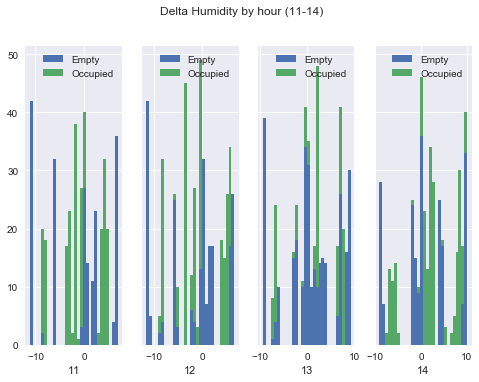

In [0]:
fig, ax = plt.subplots(1, 4, sharey='row')
fig.suptitle('Delta Humidity by hour (11-14)')


i = 0
for hour in range(11,15):
    df1 = df[(df['Occupancy'] == 0) & (df['Hour']== hour)]['Delta Humidity']
    df2 = df[(df['Occupancy'] == 1) & (df['Hour']== hour)]['Delta Humidity']
    ax[i].hist([df1,df2], stacked= True, bins = 30)
    ax[i].legend(('Empty', 'Occupied'), loc='best')
    ax[i].set_xlabel(hour)
    if i == 3:
        break
    else:
        i +=1

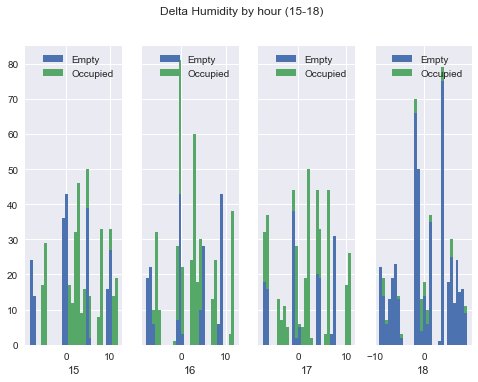

In [0]:
fig, ax = plt.subplots(1, 4, sharey='row')
fig.suptitle('Delta Humidity by hour (15-18)')


i = 0
for hour in range(15,19):
    df1 = df[(df['Occupancy'] == 0) & (df['Hour']== hour)]['Delta Humidity']
    df2 = df[(df['Occupancy'] == 1) & (df['Hour']== hour)]['Delta Humidity']
    ax[i].hist([df1,df2], stacked= True, bins = 30)
    ax[i].legend(('Empty', 'Occupied'), loc='best')
    ax[i].set_xlabel(hour)
    if i == 3:
        break
    else:
        i += 1

# ------------------------------------------------------------------------------------------

However, we might also want to add a correcting factor taking into account the passing of time. For example, that the temperature be 3 degrees higher than the median taken as benchmark might be significant if it's the same week as for the data which originated the median, but becomes progressively less significant as time goes by and, say, the weather gets warmer.

As a consequence, need to: <br/>
<li> find what day the median on average refers to and take that as correction factor = 0.
<li> find what the variation in the variable from one day to the next is
<li> derive a correcting factor that measures the expected variation per day
<li> include the correcting factor in the computation of the Delta attributes, taking into account what the distance in days is between the day of the record under consideration and the day of the benchmark median (see point a) 

However, since point a already seems too challenging (as it begs other questions, such as: would it make sense to use training records which are very far away from one another in terms of date? How would we compute this average day? Weighed average?) and the one above seems like a pretty sophisticated measure, will probably ignore this potential shortcoming of the Delta attributes for the time being (although might be worth mentioning in report, just to show we pinpointed it!).

# ------------------------------------------------------------------------------------------

## 1.4 Feature selection 2

Remaining attributes:

In [0]:
df.head()

,Temperature,Humidity,Light,CO2,Occupancy,Time,WeekDay,Hour,Minute,WorkingHours,Delta Temperature,Delta Humidity,Delta Light,Delta CO2
1743,23.18,27.272,426.0,721.250000,1,17:51:00,Wednesday,17,51,1,2.79,-0.828,420.0,207.580000
8291,23.15,27.245,426.0,713.500000,1,17:53:00,Wednesday,17,53,1,2.76,-0.855,420.0,199.830000
7214,23.10,27.200,426.0,704.500000,1,17:55:00,Wednesday,17,55,1,2.71,-0.900,420.0,190.830000
6095,23.10,27.200,419.0,701.000000,1,17:55:59,Wednesday,17,55,1,2.71,-0.900,413.0,187.330000
4165,23.10,27.200,419.0,701.666667,1,17:57:00,Wednesday,17,57,1,2.71,-0.900,413.0,187.996667


In [0]:
df = df.drop(['Temperature','Humidity', 'Light','CO2', 'Time','WeekDay', 'Hour', 'Minute'],1)
df.head()

,Occupancy,WorkingHours,Delta Temperature,Delta Humidity,Delta Light,Delta CO2
1743,1,1,2.79,-0.828,420.0,207.580000
8291,1,1,2.76,-0.855,420.0,199.830000
7214,1,1,2.71,-0.900,420.0,190.830000
6095,1,1,2.71,-0.900,413.0,187.330000
4165,1,1,2.71,-0.900,413.0,187.996667


To save new training to a file:

In [0]:
# df.to_csv('training_preprocessed.csv') 

# ------------------------------------------------------------------------------------------

# 2. Test preprocessing

In [0]:
# Set the parser datetime format
def date_obj(st):
    """
    Converts a string into a datetime object 
    """
    date_format = '%Y-%m-%d %H:%M:%S'
    return datetime.strptime(st, date_format)

dates = df_test.date
print(type(dates))

<class 'pandas.core.series.Series'>


In [0]:
df_test['Date'] = dates.apply(lambda x: date_obj(x).strftime("%m-%d-%y")) # This is useful if the comparison for dates is needed
df_test['Time'] = dates.apply(lambda x: date_obj(x).strftime("%H:%M:%S")) # This is useful for comparing the day's hours
df_test['Year'] = dates.apply(lambda x: date_obj(x).year)
df_test['Month'] = dates.apply(lambda x: date_obj(x).month)
df_test['Day'] = dates.apply(lambda x: date_obj(x).day)
df_test['WeekDay'] = dates.apply(lambda x: date_obj(x).strftime('%A'))

df_test['Hour'] = dates.apply(lambda x: date_obj(x).hour)
df_test['Minute'] = dates.apply(lambda x: date_obj(x).minute)
df_test['Second'] = dates.apply(lambda x: date_obj(x).second)

In [0]:
df_test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Date,Time,Year,Month,Day,WeekDay,Hour,Minute,Second
1285,2015-02-04 17:51:59,23.15,27.267500,429.5,714.000000,0.004783,1,02-04-15,17:51:59,2015,2,4,Wednesday,17,51,59
1090,2015-02-04 17:54:00,23.15,27.200000,426.0,708.250000,0.004772,1,02-04-15,17:54:00,2015,2,4,Wednesday,17,54,0
2070,2015-02-04 17:58:59,23.10,27.200000,419.0,689.333333,0.004757,1,02-04-15,17:58:59,2015,2,4,Wednesday,17,58,59
4636,2015-02-04 18:03:00,23.10,27.166667,419.0,683.500000,0.004751,1,02-04-15,18:03:00,2015,2,4,Wednesday,18,3,0
5762,2015-02-04 18:04:00,23.05,27.150000,419.0,687.500000,0.004734,1,02-04-15,18:04:00,2015,2,4,Wednesday,18,4,0


In [0]:
df_test['WorkingHours'] = 0
for index in df_test.index:
    if (df_test.at[index, 'WeekDay']!= 'Sunday') & (df_test.at[index, 'WeekDay']!= 'Saturday'):
        if (df_test.at[index, 'Time'] < '18:00:00') & (df_test.at[index, 'Time'] > '07:00:00'):
            df_test.at[index, 'WorkingHours'] = 1

In [0]:
df_test = df_test.drop(columns=['Date', 'date', 'Second','HumidityRatio', 'Day', 'Month','Year'])

In [0]:
for attribute in ['Temperature','Humidity','Light', 'CO2']:
        df_test['Delta ' + attribute] = 0.0        
for index in df_test.index:
    for attribute in ['Temperature','Humidity','Light', 'CO2']:
        for hour in df_test['Hour'].unique():
            if df_test.at[index, 'Hour'] == hour:
                df_test.at[index, 'Delta ' + attribute] = df_test.at[index, attribute] - df_hbh[hour, 0][attribute]['median']

In [0]:
df_test.head()

,Temperature,Humidity,Light,CO2,Occupancy,Time,WeekDay,Hour,Minute,WorkingHours,Delta Temperature,Delta Humidity,Delta Light,Delta CO2
1285,23.15,27.267500,429.5,714.000000,1,17:51:59,Wednesday,17,51,1,2.76,-0.832500,423.5,200.330000
1090,23.15,27.200000,426.0,708.250000,1,17:54:00,Wednesday,17,54,1,2.76,-0.900000,420.0,194.580000
2070,23.10,27.200000,419.0,689.333333,1,17:58:59,Wednesday,17,58,1,2.71,-0.900000,413.0,175.663333
4636,23.10,27.166667,419.0,683.500000,1,18:03:00,Wednesday,18,3,0,1.81,-1.793333,419.0,58.000000
5762,23.05,27.150000,419.0,687.500000,1,18:04:00,Wednesday,18,4,0,1.76,-1.810000,419.0,62.000000


In [0]:
df_test = df_test.drop(['Temperature','Humidity', 'Light','CO2', 'Time','WeekDay', 'Hour', 'Minute'],1)


In [0]:
df_test.head()

,Occupancy,WorkingHours,Delta Temperature,Delta Humidity,Delta Light,Delta CO2
1285,1,1,2.76,-0.832500,423.5,200.330000
1090,1,1,2.76,-0.900000,420.0,194.580000
2070,1,1,2.71,-0.900000,413.0,175.663333
4636,1,0,1.81,-1.793333,419.0,58.000000
5762,1,0,1.76,-1.810000,419.0,62.000000


In [0]:
#df_test.to_csv('test_preprocessed.csv') 

## Data partitioning (done, deactivated code)

from sklearn.model_selection import train_test_split


df_whole = pd.read_csv("occupancy_data/whole_data.csv")
df_whole = df_whole.drop('Unnamed: 0', 1)

#preparing df for test-train split
data = df_whole.values

#performing split
training_set, test_set = train_test_split(data, test_size=0.33, random_state=100)

df_train = pd.DataFrame(training_set)
df_train.columns = df_whole.columns
df_train.to_csv("occupancy_data/training.csv")

df_test = pd.DataFrame(test_set)
df_test.columns = df_whole.columns
df_test.to_csv("occupancy_data/test.csv")

# ------------------------------------------------------------------------------------------

## Variable transformations (not sure useful, deactivated code)

def log_transf(number):
    if number == 0:
        return 0
    else:
        return np.log(number)

Below: just playing around with 'Light'. Not sure it's any use.

light_log = df['Light'].apply(log_transf)

Plot of 'Light' logarithmised (base = e)

plt.hist(light_log, 20)

co2_log = df['CO2'].apply(log_transf)

Plot of 'CO2' logarithmised (base = e)

plt.hist(co2_log, 30)

# ------------------------------------------------------------------------------------------

## N.B.: tried code below (up to ---). Classification on test1 w/ decision tree really bad:

Train Accuracy 1.0
Train F1-score [1. 1.]

Test Accuracy 0.7926711668273867

Test F1-score [0.15686275 0.88180319]


              precision    recall  f1-score   support

           0       0.11      0.26      0.16        77
           1       0.93      0.84      0.88       960

    accuracy                           0.79      1037
    
--> probably not a good idea to altogether eliminate records with hours for which occupancy always = 0.

<b>Goal: eliminate hours at which no one's ever at the office to reduce bias of comparison between attribute values for Occupancy = 0 and Occupancy = 1</b>

df_mod['Hour'].unique()

hours_to_be_deleted = np.arange(19,24)
for hour in hours_to_be_deleted:
    df_mod = df_mod[df_mod['Hour']!= hour]

hours_to_be_deleted2 = np.arange(0,7)
for hour in hours_to_be_deleted2:
    df_mod = df_mod[df_mod['Hour']!= hour]

df_mod['Hour'].unique()

df_mod[df_mod['Occupancy']==0]['Occupancy'].count()

df_mod[df_mod['Occupancy']==1]['Occupancy'].count()

--> the two classes are much more balanced!

for day in df_mod['WeekDay'].unique():
    times_occupancy_0 = df_mod[(df_mod['WeekDay'] == day ) & (df_mod['Occupancy'] == 0)]['Time'].unique()
    
    times_condensed = []
    index = 0
    for element in times_occupancy_0:
        if index == 0:
            times_condensed.append(element)
            hours = element[0:2]
            #minutes_init = element[3:5]
        if index == times_occupancy_0.size - 1:
            times_condensed.append(element)
        elif element[0:2] != hours:
            if times_occupancy_0[index-1] not in times_condensed:
                times_condensed.append(times_occupancy_0[index-1])
            times_condensed.append(element)
            hours = element[0:2]
        index +=1
    print(day)
    print(times_condensed)

df_mod = df_mod[(df_mod['Time']<'18:07:00') & (df_mod['Time']>'07:40:00')]

for day in df_mod['WeekDay'].unique():
    times_occupancy_0 = df_mod[(df_mod['WeekDay'] == day ) & (df_mod['Occupancy'] == 0)]['Time'].unique()
    
    times_condensed = []
    index = 0
    for element in times_occupancy_0:
        if index == 0:
            times_condensed.append(element)
            hours = element[0:2]
            #minutes_init = element[3:5]
        if index == times_occupancy_0.size - 1:
            times_condensed.append(element)
        elif element[0:2] != hours:
            if times_occupancy_0[index-1] not in times_condensed:
                times_condensed.append(times_occupancy_0[index-1])
            times_condensed.append(element)
            hours = element[0:2]
        index +=1
    print(day)
    print(times_condensed)

df_mod[df_mod['Occupancy']==0]['Occupancy'].count()

df_mod[df_mod['Occupancy']==1]['Occupancy'].count()

--> the two classes are now balanced (trend slightly inverted, as 1's outweigh the 0's).

So, what we've done is basically remove all records which referred to times for which the room was never occupied throughout the week. This means that the data we now have at our disposal only refer to hours at which the room could have potentially been occupied, which (I think) makes the data space much more descriptive of the situation we are actually interested in. Still, it might be a bit ballsy. Certainly needs explaining. Will probably need to include some sort of preliminary rule in classification model that goes like this: 'If office is closed, then the room is empty', or 'At night, the room is always empty'. This might translate to an implementation in which the user first feeds the software with the possible working hours, so that by default outside those working hours the room is considered to be empty. Makes sense from a practical standpoint, not so sure it's what they're after in this theoretical setting.

df_mod.to_csv('occupancy_data\test1_without_always_0_hours.csv') #(to save this to a file)

# ------------------------------------------------------------------------------------------